In [125]:
import base64
import datetime
import itertools
import json
import math
import operator
import os
import pickle
import random
import re
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

In [126]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [127]:
def get_param_combos(params):
    keys = params.keys()
    param_values = [params[k] for k in keys]
    return [dict(zip(keys, p)) for p in itertools.product(*param_values)]

def grid_search_xgb(train_X, train_y, test_X, test_y, num_rounds, params):
    best_score = None
    best_params = None
    best_model = None
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgtest = xgb.DMatrix(test_X, label=test_y)
    
    for pc in get_param_combos(params):
    
        model = xgb.train(
            params=pc,
            dtrain=xgtrain,
            num_boost_round=num_rounds)
        pred_test_y = model.predict(xgtest)
        e = sklearn.metrics.log_loss(test_y, pred_test_y)
        print '{0:20}{1}'.format('mlogloss', e)
        print
        for k in pc:
            print '{0:20}{1}'.format(k, pc[k])
        print '=' * 50
    
        if (best_score is None) or (e < best_score):
            best_score = e
            best_params = pc
            best_model = model
    
    return best_score, best_params, best_model

# Load the Data

In [128]:
tr = pd.read_csv('tmp/combined_train.csv', index_col='id')
trl = tr.interest_level.copy()
del tr['interest_level']

In [129]:
te = pd.read_csv('tmp/combined_test.csv', index_col='id')
del te['interest_level']

In [130]:
te.head(2)

,listing_id_x,bathrooms,num_bathrooms_bucket,bedrooms,num_bedrooms_bucket,num_apts_in_building,num_apts_in_building_q10,building_code,created_month,created_day_of_month,...,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399
id,,,,,,,,,,,,,,,,,,,,,
0,7142618,1.0,1,1,1,8.0,0.1,5535,6,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7210040,1.0,1,2,2,NaN,NaN,0,6,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
tt_lim = int(0.8 * len(tr))
ho_tr_f = tr[:tt_lim]
ho_te_f = tr[tt_lim:]
ho_tr_l = trl[:tt_lim]
ho_te_l = trl[tt_lim:]

ho_xgtrain = xgb.DMatrix(ho_tr_f, label=ho_tr_l)
ho_xgtest = xgb.DMatrix(ho_te_f)

In [132]:
ho_te_f.head(1)

,listing_id_x,bathrooms,num_bathrooms_bucket,bedrooms,num_bedrooms_bucket,num_apts_in_building,num_apts_in_building_q10,building_code,created_month,created_day_of_month,...,tfidf_390,tfidf_391,tfidf_392,tfidf_393,tfidf_394,tfidf_395,tfidf_396,tfidf_397,tfidf_398,tfidf_399
id,,,,,,,,,,,,,,,,,,,,,
99267,6913513,1.0,1,2,2,40.0,0.4,8203,4,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Baseline prediction

In [133]:
best_params = {'alpha': 0.0,
 'colsample_bylevel': 1.0,
 'colsample_bytree': 0.8,
 'eta': 0.075,
 'eval_metric': 'mlogloss',
 'gamma': 0.0,
 'lambda': 1.0,
 'max_depth': 6,
 'min_child_weight': 1,
 'num_class': 3,
 'objective': 'multi:softprob',
 'subsample': 0.9}
model = xgb.train(
            params=best_params,
            dtrain=ho_xgtrain,
            num_boost_round=100)
pred_test_y = model.predict(ho_xgtest)

# Predict for each level separately

In [134]:
DEFAULT_PARAMS = {
 'alpha': 0.0,
 'colsample_bylevel': 1.0,
 'colsample_bytree': 0.8,
 'eta': 0.075,
 'eval_metric': 'logloss',
 'gamma': 0.0,
 'lambda': 1.0,
 'max_depth': 6,
 'min_child_weight': 1,
#  'num_class': 3,
 'objective': 'reg:logistic',
 'subsample': 0.9
}
def train_separately(d, labels_orig, test_d, params=DEFAULT_PARAMS, num_boost_round=100):
    preds = []
    models = []
    for i in range(3):
        lbl = labels_orig.map(lambda x: x == i)
        ho_xgtrain = xgb.DMatrix(d, label=lbl)
        ho_xgtest = xgb.DMatrix(test_d)
        model = xgb.train(
            params=params,
            dtrain=ho_xgtrain,
            num_boost_round=num_boost_round)
        pred_test_y = model.predict(ho_xgtest)
        preds.append(pred_test_y)
        models.append(model)
    return preds, models

In [ ]:
preds, models = train_separately(ho_tr_f, ho_tr_l, ho_te_f, num_boost_round=10)

In [ ]:
sep_pred = pd.DataFrame()
sep_pred['high'] = pd.Series(preds[0])
sep_pred['medium'] = pd.Series(preds[1])
sep_pred['low'] = pd.Series(preds[2])
sep_pred.loc[:, 'listing_id'] = ho_te_f.listing_id_x.astype(int64).tolist()
sep_pred.index = ho_te_f.index
sep_pred[['high', 'medium', 'low']].plot(kind='kde')

In [ ]:
bl_pred = pd.DataFrame(pred_test_y, columns=['high_bl', 'medium_bl', 'low_bl'])
bl_pred.index= ho_te_f.index
bl_pred[['high_bl', 'medium_bl', 'low_bl']].plot(kind='kde')

## Combine baseline and out prediction and ground truth

In case we want to analyze which model goes wrong where

In [ ]:
cmp_preds = pd.concat([sep_pred, bl_pred,  ho_te_l.to_frame('real_label')], axis=1)

def get_txt_label(code):
    lbls = ['high', 'medium', 'low']
    return lbls[code]
cmp_preds.loc[:, 'lbl_txt'] = cmp_preds.real_label.map(get_txt_label) 
cmp_preds.head(5)


In [ ]:
baseline_logloss = sklearn.metrics.log_loss(ho_te_l, pred_test_y)
print "Baseline model's logloss: \t\t\t{}".format(baseline_logloss)

separate_logloss = sklearn.metrics.log_loss(ho_te_l, np.array(preds).transpose())
print "Separate-level model's logloss: \t\t{}".format(separate_logloss)



# Feature Importances

In [ ]:
def feature_importance_with_plot(model, NUM_FEATURES = 50):
    fscores = model.get_score(importance_type='gain')
    fscores = sorted(fscores.items(), key=operator.itemgetter(1))
    fscores.reverse()
    fscores = fscores[:NUM_FEATURES]
    fi = pd.DataFrame({
            'feature': [fs[0] for fs in fscores],
            'importance': [fs[1] for fs in fscores]})
    plt.figure(figsize=(12, NUM_FEATURES / 4))
    _ = sns.barplot(
            x='importance',
            y='feature',
            data=fi,
            color='salmon')
    
    with open('tmp/tfidf_vocabulary_features.json') as vocab_file:    
        feature_vocabulary = json.load(vocab_file)

    vocabulary_as_list = [None] * len(feature_vocabulary)
    for w, idx in feature_vocabulary.iteritems():
        vocabulary_as_list[idx] = w

    def get_raw_feature(f):
        if f.startswith('tfidf_'):
            idx = int(f.replace('tfidf_', ''))
            return vocabulary_as_list[idx]
        else:
            return ""

    fi.loc[:, 'raw_feature'] = fi.feature.map(get_raw_feature )
    return fi

In [ ]:
fi_baseline = feature_importance_with_plot(model, 30)

In [ ]:
# Feature importance for class "high"
fi_high = feature_importance_with_plot(models[0], 30)

In [ ]:
# Feature importance for class "medium"
fi_medium = feature_importance_with_plot(models[1], 30)

In [ ]:
# Feature importance for class "low"
fi_low = feature_importance_with_plot(models[2], 30)

# Submission

In [118]:
xgtrain = xgb.DMatrix(tr, label=trl)
xgtest = xgb.DMatrix(te)

In [119]:
# use DEFAULT_PARAMS from above
sbm_preds, sbm_models = train_separately(tr, trl, te, num_boost_round=400)
sbm_pred_test_y =  np.array(sbm_preds).transpose()

In [120]:
out_df = pd.DataFrame(sbm_pred_test_y)
print len(out_df)
out_df.head(10)

74659


,0,1,2
0,0.071261,0.471297,0.349327
1,0.168121,0.088096,0.624283
2,0.006113,0.025993,0.970607
3,0.259095,0.436734,0.219602
4,0.010617,0.326089,0.752677
5,0.005206,0.213373,0.781456
6,0.000533,0.011461,0.981704
7,0.047712,0.298786,0.581426
8,0.006375,0.108972,0.894918
9,0.003759,0.034550,0.977285


In [121]:
out_df.columns = ['high', 'medium', 'low']
out_df.loc[:, 'listing_id'] = te.listing_id_x.astype(int64).tolist()
out_df.to_csv('output/xgb_sep_400.csv', index=False)

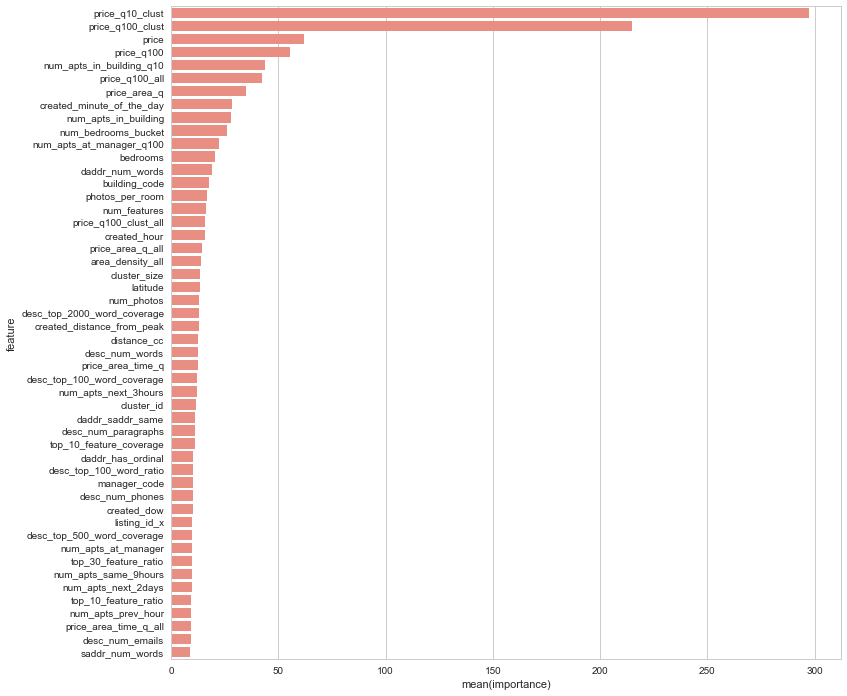

In [122]:
fi_high = feature_importance_with_plot(models[0], 50)

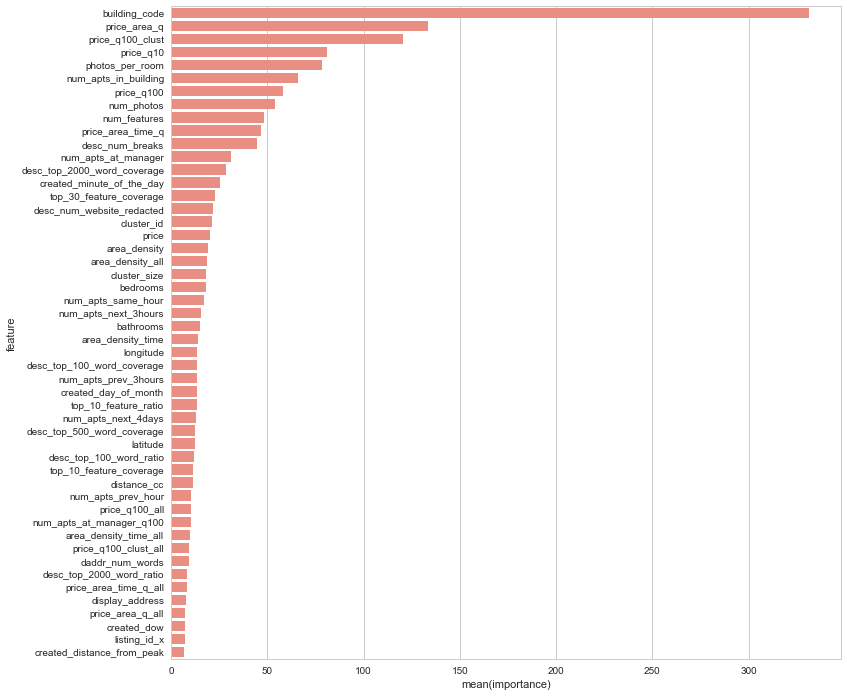

In [123]:
fi_medium = feature_importance_with_plot(models[1], 50)

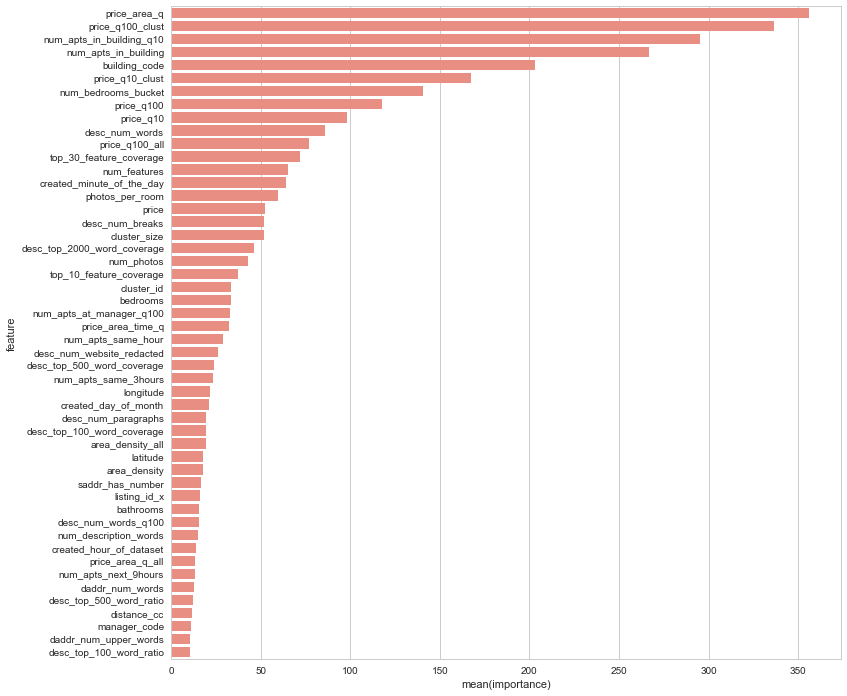

In [124]:
fi_low = feature_importance_with_plot(models[2], 50)